In [1]:
import numpy as np
import matplotlib
#matplotlib.use('WebAgg')
#matplotlib.use('Qt4Cairo')
#matplotlib.use('Qt5Cairo')
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt



In [2]:
def func(x):
    return np.exp(-(1000.*(x[0]-0.8)**2+500.*(x[1]-0.2)**2 +1800.*(x[2]-0.3)**2))  


In [3]:
#example of multiple inputs
'''def func1(x):
    return np.exp(-(10.*(x[0]-0.8)**2+50.*(x[1]-0.2)**2 +10.*(x[2]-0.3)**2))  

print func1(np.array([[0.1,0.1],[0.5,0.2],[0.4,0.8]]))
print func1([0.1,0.5,0.4])
print func1([0.1,0.2,0.8])''';

In [4]:
def Metropolis(Target,xin,N=10000,eps=0.01,burn_in=0,thinning=10,_fixed_interval=True):
    '''
    burn_in (integer): do not store the first 'burn_in' accepted steps (the first few steps could be in a region with low probability).
    thinning (integer): store 1 every 'thinning' accepted steps (makes the sample more independent).
    _fixed_interval (boolean): if True keps x in [0,1].
    '''
    Dim=len(xin)
    accepted=[]

    _n_b=0
    _n_t=0

    x=xin[:]
    
    func_x=Target(x)

    for i in np.arange(N):
        
        can=[]
        for d in range(Dim):
            while True:
                #step=(np.random.rand()*2-1)*eps[d]
                step=np.random.normal(0,eps[d])
                
                if _fixed_interval:
                    if x[d]+step<1 and x[d]+step>0:#check if x stays inside the cube [0,1]^dim (I want the point in here for integration)
                        break
                else:
                    break

            can.append(x[d] + step) #candidate

        func_can=Target(can)


        if func_x<1e-50:
            a=1
        else:    
            a = min([1.,func_can/func_x]) #acceptance probability for symmetric prior
        u = np.random.rand()

        if u < a :
            x = can[:]
            _n_b+=1
            _n_t+=1
            if _n_b>=burn_in and _n_t>thinning:

                _n_t=0
                accepted.append(x)#accept sample


        func_x=Target(can)
    return np.array(accepted)

In [5]:
#run Metropolis

#accepted=Metropolis(Target=func,xin=[0.5,0.1,0.7],N=50000,eps=[0.01,0.04,0.02],burn_in=0,thinning=0)#run this first
accepted=Metropolis(Target=func,xin=[0.5,0.1,0.7],N=200000,eps=[0.01,0.04,0.02],burn_in=50000,thinning=80)#then run this

_len=len(accepted)
_Dim=len(accepted[0])
print (_len)

886


<IPython.core.display.Javascript object>


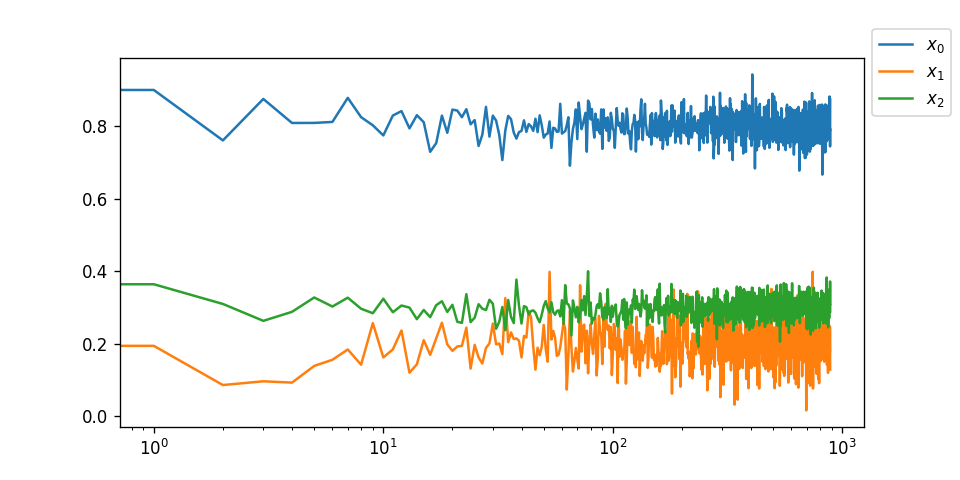

In [6]:
#===========================================================================================================================================#
#traceplot of x (use it to determine burn_in).
_trace=True #set True to see the plot
if _trace:
    
    plt.figure(figsize=(8,4))
    for d in range(_Dim):
        
        plt.plot(np.arange(_len), [i[d] for i in accepted  ] ,label='${}{}$'.format('x_',str(d)) )
        
        plt.legend(bbox_to_anchor=(1, 1.1))

    plt.xscale('log')
    
    plt.show()
#===========================================================================================================================================#

-0.0004375248994432771 0.03650170725269385
-0.003451905956680913 0.029134199985915536
0.007251203357981319 0.03242228942412513


<IPython.core.display.Javascript object>


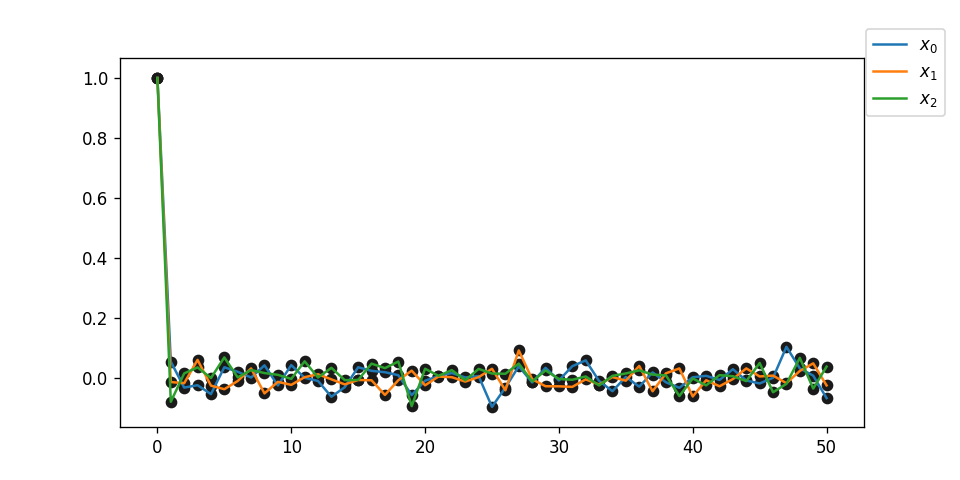

In [8]:
#===========================================================================================================================================#
#plot the autocorrelation function (ACF) (use it to determine the thinning)
_ACF=True #set True to see the plot
if _ACF:
    def ACF(X,N,n=5):#returns the first N ACFs
        _mu=np.mean(X)
        _len=len(X)

        if N>_len:
            N=_len

        _g=lambda k:np.sum([(X[i]-_mu)*(X[i+k]-_mu) for i in np.arange(1,_len-k)])
        acf=[_g(k) for k in np.arange(0,N,n)]
        return np.array(acf)/_g(0)

    N=51

    if N>_len:
        N=_len
    n=1

    acf= [ ACF([i[d] for i in accepted],N,n) for d in range(_Dim) ]

    for i in range(_Dim):
        print( np.mean(acf[i][10:]),np.sqrt(np.var(acf[i][10:],ddof=1)))
    
    
    plt.figure(figsize=(8,4))
    for d in range(_Dim):
        plt.plot(np.arange(0,N,n),acf[d],label='${}{}$'.format('x_',str(d)) )
        plt.scatter(np.arange(0,N,n),acf[d],color=(0.1,0.1,0.1,1))
        plt.legend(bbox_to_anchor=(1.12, 1.1))
    plt.show()
#===========================================================================================================================================#

Points per bin= 1 No. bins= 886 Total points= 886
Points per bin= 2 No. bins= 443 Total points= 886
Points per bin= 4 No. bins= 221 Total points= 884
Points per bin= 8 No. bins= 110 Total points= 880
Points per bin= 16 No. bins= 55 Total points= 880
Points per bin= 32 No. bins= 27 Total points= 864
Points per bin= 64 No. bins= 13 Total points= 832
Points per bin= 128 No. bins= 6 Total points= 768
Points per bin= 256 No. bins= 3 Total points= 768


<IPython.core.display.Javascript object>


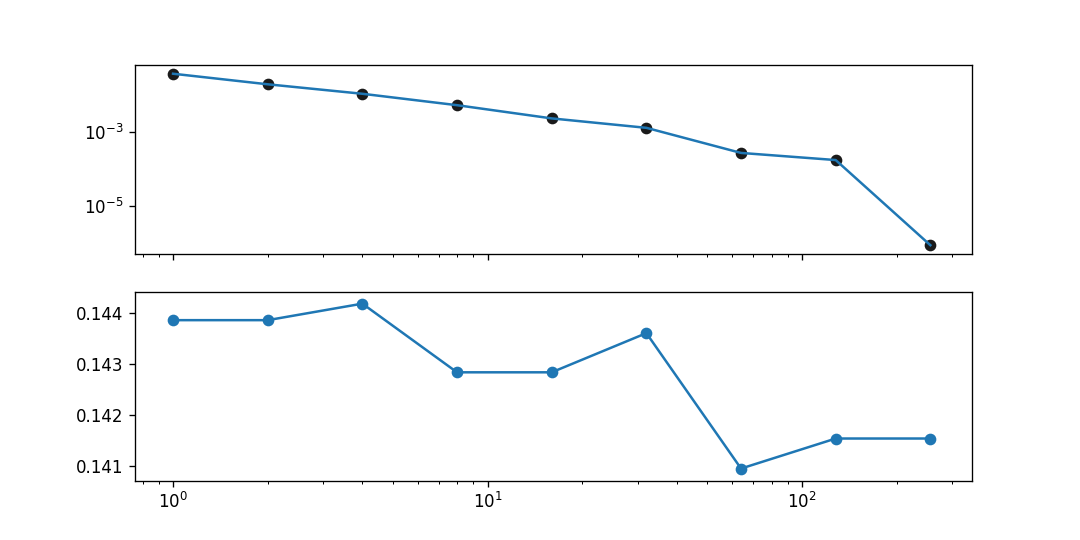

In [10]:
#Plot sigma and mean of func (or x if you uncomment it) for various binning.
#===========================================================================================================================================#
#break the accepted in bins of NB length and plot the variance for a various number of bins.
_NOB=True #set True to see the plots
if _NOB:

    means=[]
    vars=[]
    NBs=[]

    _len=len(accepted)
    for k in np.arange(0,50):
        NB=int(2**k)#batch length
        bins=int(_len/float(NB))
        if bins<2:
            break

        print( r'Points per bin=', NB ,r'No. bins=', bins, r'Total points=',NB*bins)

        batch_means= [ np.mean([ func(  [accepted[batch*NB+i][d] for d in np.arange(_Dim)]) for i in np.arange(NB) ])  for batch in np.arange(bins)]
        #batch_means= [ np.mean([ accepted[batch*NB+i] for i in np.arange(NB) ])  for batch in np.arange(bins)]
        means.append(np.mean(batch_means))
        vars.append( np.var(batch_means,ddof=1))



        #NBs.append(bins)
        NBs.append(NB)

    fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(9, 4.5),sharex=True)

    ax[0].plot( NBs,vars )
    ax[0].scatter( NBs,vars,color=(0.1,0.1,0.1,1) )
    ax[0].set_yscale('log')
    ax[0].set_xscale('log')

    ax[1].plot( NBs,means )
    ax[1].scatter( NBs,means )
    ax[1].set_xscale('log')

    plt.show()
#===========================================================================================================================================#